In [ ]:
#this notebook is implemnted to classify 6 different types of surface defect using transfer learning
# MobileNet V2 model structure is used as base model

In [1]:
#import neccesary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds 
import glob
from skimage import transform
import cv2
import seaborn as sns
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report


In [2]:
#since images are stored in different folders, a function is created to read them from file and store them in a list
def Load_Images(folder):
    path=folder+"\\*.jpg"
    imgs=[]
    for img in glob.glob(path):
        n=cv2.imread(img)
        imgs.append(n)
    return imgs

In [3]:
#load the data -
#immages are loaded using the function implemented above
X_BL_or=Load_Images("C:\\Users\\Deabae\\OneDrive - University of Calgary\\W22\\ENEL 645\\Surface_Defect\\Dataset\\MT_Blowhole\\Imgs")#Blowhole
X_BR_or=Load_Images("C:\\Users\\Deabae\\OneDrive - University of Calgary\\W22\\ENEL 645\\Surface_Defect\\Dataset\\MT_Break\\Imgs")#Break
X_CR_or=Load_Images("C:\\Users\\Deabae\\OneDrive - University of Calgary\\W22\\ENEL 645\\Surface_Defect\\Dataset\\MT_Crack\\Imgs")#Crack
X_FY_or=Load_Images("C:\\Users\\Deabae\\OneDrive - University of Calgary\\W22\\ENEL 645\\Surface_Defect\\Dataset\\MT_Fray\\Imgs")#Fray
X_FR_or=Load_Images("C:\\Users\\Deabae\\OneDrive - University of Calgary\\W22\\ENEL 645\\Surface_Defect\\Dataset\\MT_Free\\Imgs")#Free
X_UN_or=Load_Images("C:\\Users\\Deabae\\OneDrive - University of Calgary\\W22\\ENEL 645\\Surface_Defect\\Dataset\\MT_Uneven\\Imgs")#Uneven

print(len(X_BL_or))# length of a list is printed to make sure reading files is succeeded

115


In [4]:
#since we want to use only a portion of "Free" samples, we are selecting 108 samples from free class randomly
random_ind = np.random.choice(np.arange(len(X_FR_or), dtype = int),size = 108, replace = False)
X_FR_or=np.array(X_FR_or)[random_ind].tolist()
print(len(X_FR_or))

108


C:\Users\Deabae\AppData\Local\Temp/ipykernel_15000/2177913430.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_FR_or=np.array(X_FR_or)[random_ind].tolist()


In [5]:
#all lists of classes are added to a list to let us itterate through them in future steps
All_sets=[]
All_sets.append(X_BL_or)
All_sets.append(X_BR_or)
All_sets.append(X_CR_or)
All_sets.append(X_FY_or)
All_sets.append(X_FR_or)
All_sets.append(X_UN_or)
print(len(All_sets))#the number of items in our main list is printed to make sure desired job is finished

6


In [6]:
#to find out the largest image size in the dataset we itterate through all the samples and store largest image dimensions
all_sizes1=[]
for S in All_sets:
    set_sizes=[]
    for img in S:
        set_sizes.append(img.shape)
        #print(img.shape)
    print('Max : ',np.amax(set_sizes,axis=0))
    all_sizes1.append(np.amax(set_sizes,axis=0))
    
print('Max-> ',np.amax(all_sizes1,axis=0))
max_img_Size=np.amax(all_sizes1,axis=0)

Max :  [398 512   3]
Max :  [392 632   3]
Max :  [403 606   3]
Max :  [372 616   3]
Max :  [385 618   3]
Max :  [385 620   3]
Max->  [403 632   3]


In [7]:
#concatenate all data 

#first number samples in each class is shown 
for S in All_sets:
    print('Length : ',len(S))

#and all the sublist are concatenated to form a general list of samples
X=X_BL_or+X_BR_or+X_CR_or+X_FY_or+X_FR_or+X_UN_or

X_num=len(X)
print('total-> ',X_num)

Length :  115
Length :  85
Length :  57
Length :  32
Length :  108
Length :  103
total->  500


In [8]:
#class names are added to a list so that we can use this later to print out labels
class_names = ["Blowhole", "Break",  "Crack", "Fray", "Free","Uneven" ] 

In [9]:
#labels are create for all the samples as integer values
Y=[None]*X_num
done=0
Att=0
for S in All_sets:
    for i in np.arange(done,done+len(S)):
        Y[i]=Att 
    Att+=1
    done+=len(S)
print(len(Y))
print(Y[::20])

500
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5]


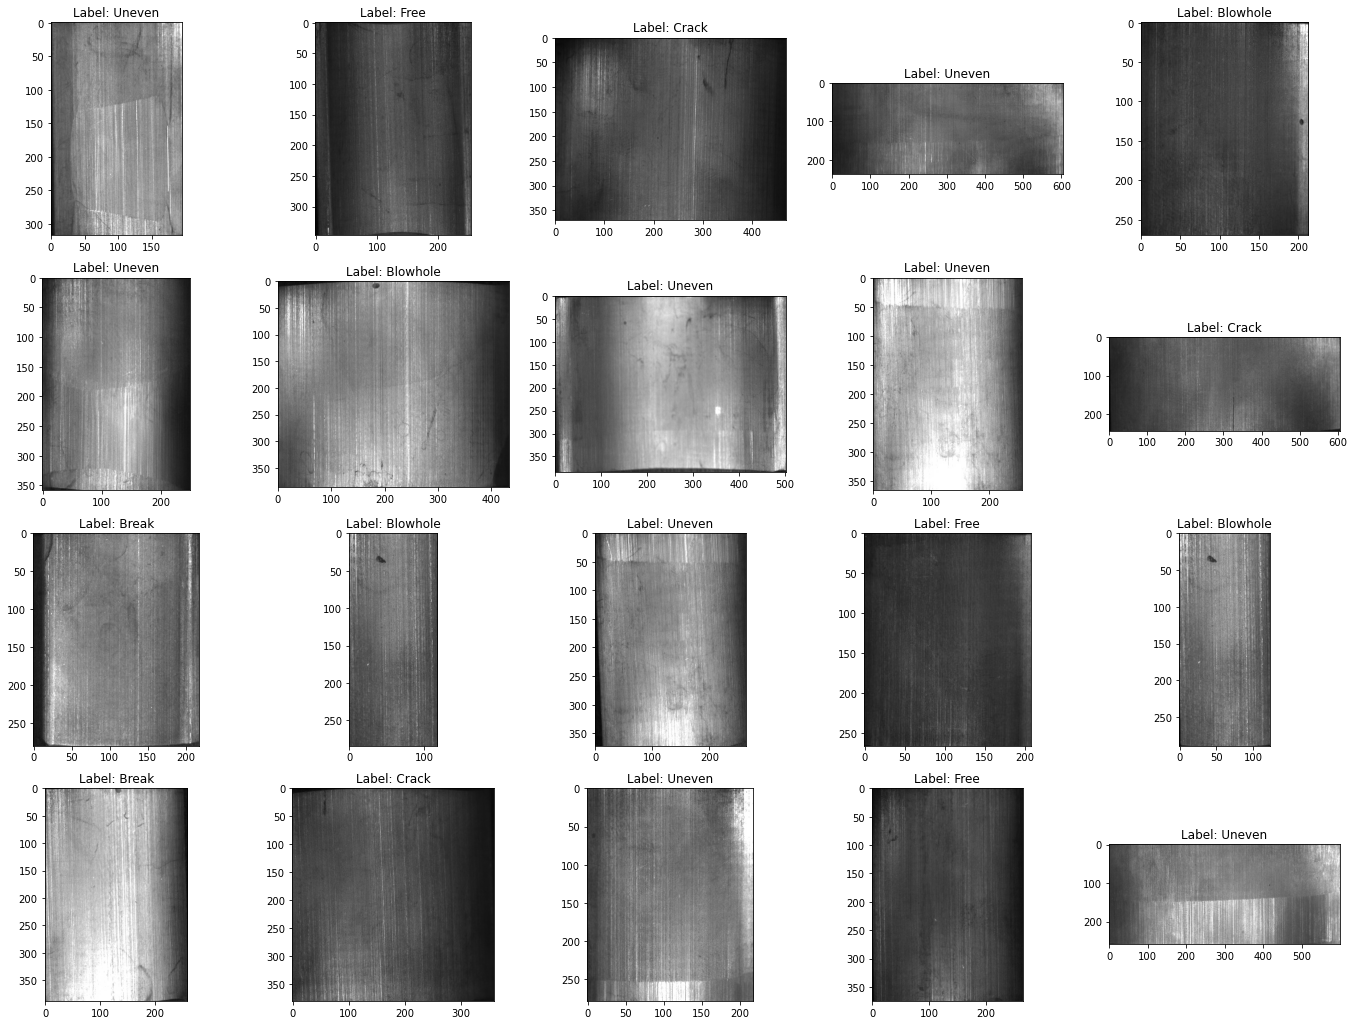

In [10]:
#show samples of the data -> Data exploration
sample_indexes = np.random.choice(np.arange(X_num, dtype = int),size = 20, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,5,ii+1)
    plt.imshow(X[jj])
    plt.title("Label: "+ class_names[Y[jj]])
plt.show()

In [10]:
#once again largest size of selected samples is investigated
all_sizes2=[]
set_sizes2=[]
for img in X:
    set_sizes2.append(img.shape)
    #print(img.shape)
print('Max : ',np.amax(set_sizes2,axis=0))
all_sizes2.append(np.amax(set_sizes2,axis=0))
    
print('Max-> ',np.amax(all_sizes2,axis=0))
max_img_Size=np.amax(all_sizes2,axis=0)

Max :  [403 632   3]
Max->  [403 632   3]


In [11]:
#Stretch all  images to similar size
dim=(640,400)
for i in range(len(X)):
    if X[i].shape[0]<400 or X[i].shape[1]<640:
        X[i]=cv2.resize(X[i],dim)

In [12]:
#resize all stretched images to a smaller size to preserve memory during training
for i in range(len(X)):
    X[i]=cv2.resize(X[i],(320,200))

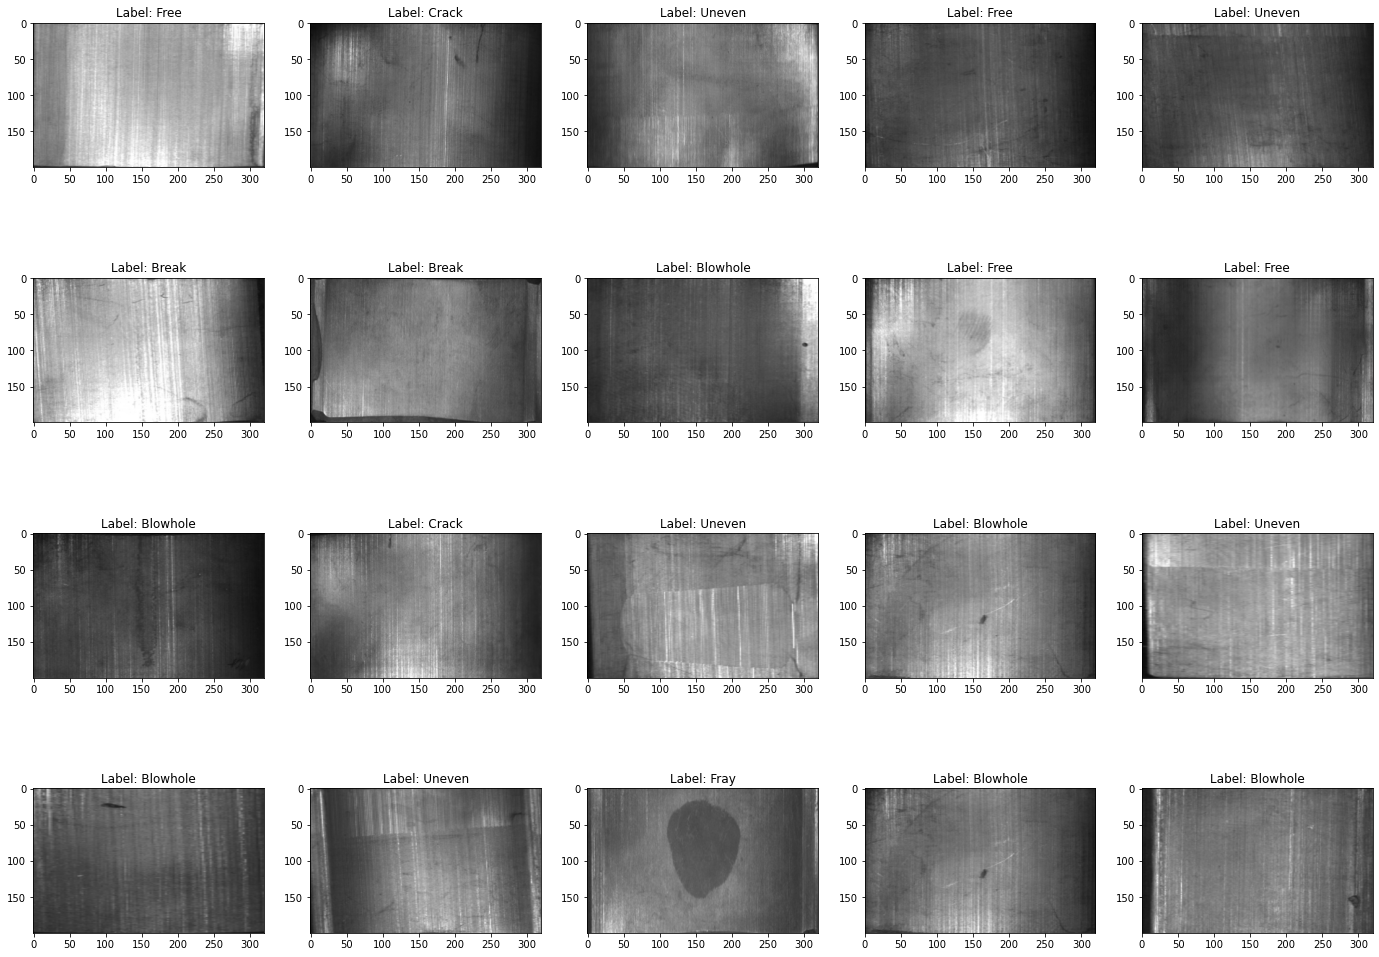

In [13]:
#show samples of the data after resize -> Data exploration
sample_indexes = np.random.choice(np.arange(X_num, dtype = int),size = 20, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,5,ii+1)
    plt.imshow(X[jj])
    plt.title("Label: "+ class_names[Y[jj]])
plt.show()

In [14]:
#converting the list of sample to an array to let the split function divide training, validation and test sets.
X=np.array(X)

In [15]:
#tensorflow train_test split function is utilized to split the samples into 3 sets
X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.2, random_state=42, shuffle=True)

In [16]:
#calculate data distribution to illustrate them in a bar chart
Y_cat=pd.Index(Y)
Y_cat_count=Y_cat.value_counts()
Y_cat_count=Y_cat_count.sort_index()
print('Total: ',Y_cat_count.values)

Y_Train_cat=pd.Index(Y_train)
Y_Train_cat_count=Y_Train_cat.value_counts()
Y_Train_cat_count=Y_Train_cat_count.sort_index()
print('Train: ',Y_Train_cat_count.values)

Y_Val_cat=pd.Index(Y_val)
Y_Val_cat_count=Y_Val_cat.value_counts()
Y_Val_cat_count=Y_Val_cat_count.sort_index()
print('Val: ',Y_Val_cat_count.values)

Y_Test_cat=pd.Index(Y_test)
Y_Test_cat_count=Y_Test_cat.value_counts()
Y_Test_cat_count=Y_Test_cat_count.sort_index()
print('Test: ',Y_Test_cat_count.values)

    

Total:  [115  85  57  32 108 103]
Train:  [66 61 42 17 68 66]
Val:  [19 12 11 10 15 13]
Test:  [30 12  4  5 25 24]


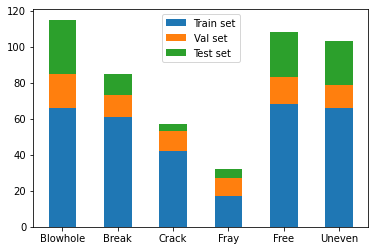

In [16]:
#plot data distribution
#import seaborn as sns
fig_dis, ax=plt.subplots()

ax.bar(class_names, Y_Train_cat_count.values,0.5,label='Train set')
ax.bar(class_names, Y_Val_cat_count.values,0.5,bottom=Y_Train_cat_count.values,label='Val set')
ax.bar(class_names, Y_Test_cat_count.values,0.5,bottom=Y_Train_cat_count.values+Y_Val_cat_count.values,label='Test set')


ax.set_ylabel='Count'
ax.set_xlabel='Categories'
ax.legend()
plt.show()



In [17]:
#one-hot-encoding
#labels are converted to one-hot-encoding
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)


print("Labels:")
print(Y_train[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[::30])

Labels:
[4, 1, 4, 2, 3]

One hot encoded labels:
[[0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [18]:
#definition of early stop condition and monitoring criteria
model_name = "best_model_defect_12.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule is also defined to decrease the LR during the training (divide by a factor of 2, each 4 epochs)
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [20]:
#data augmentation to flip images horizontally and verticall
#batch size is also selected to be 32
batch_size = 32
gen_params = {"horizontal_flip":True,"vertical_flip":True}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size) 

-0.22188646 0.40252444
-0.9529412 1.0


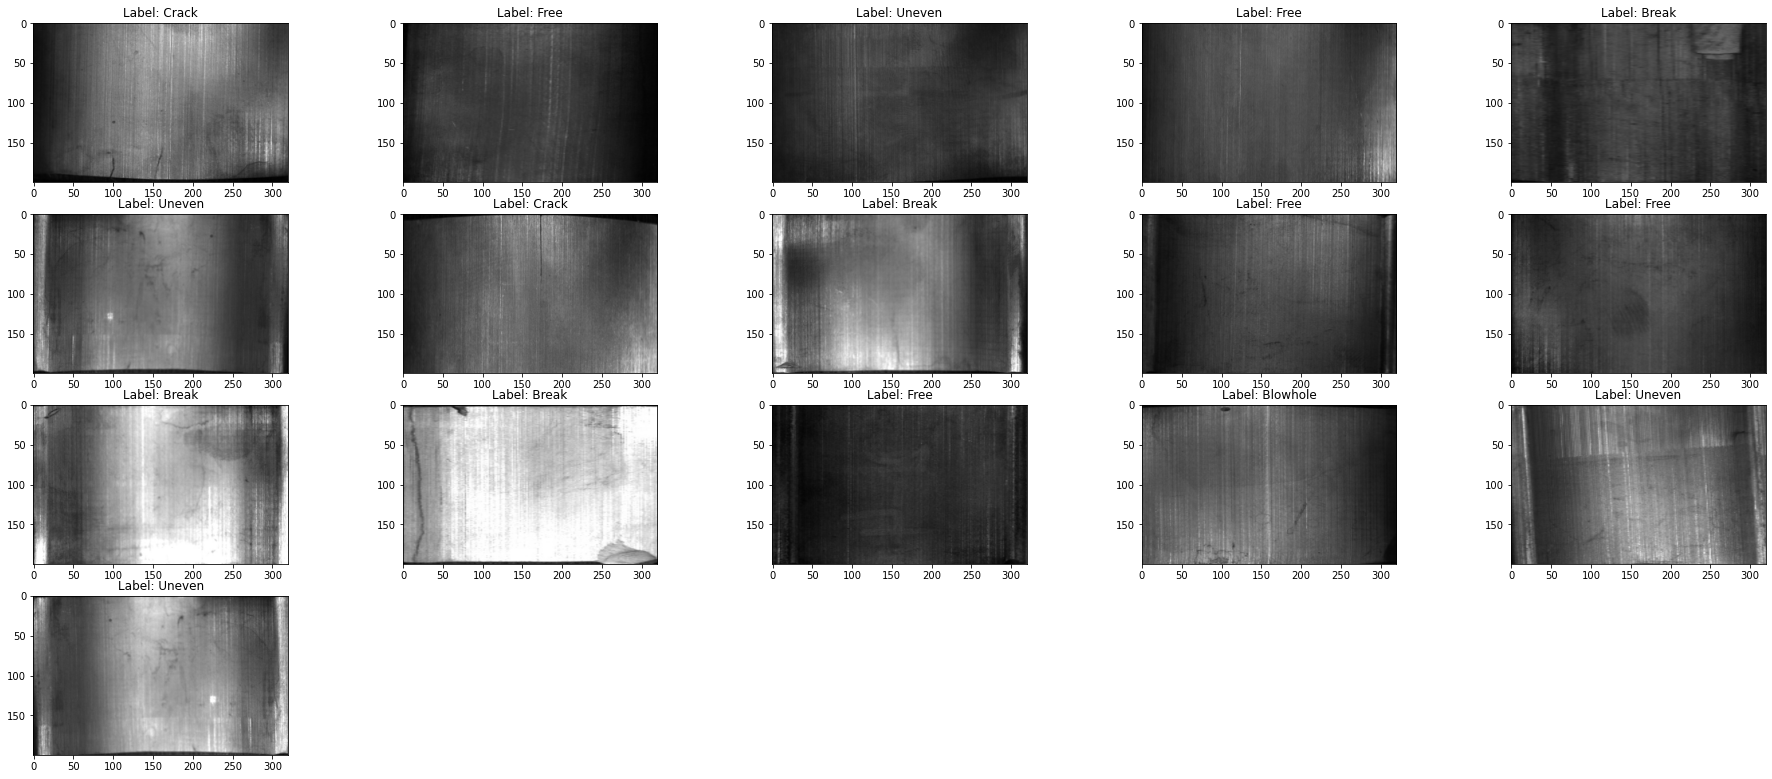

In [20]:
# Disaplying some samples after data augmentation
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_flow.__getitem__(0)
print(Xbatch.mean(),Xbatch.std())
print(Xbatch.min(),Xbatch.max())
for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    plt.title("Label: %s" %class_names[int(Ybatch[ii].argmax())])
plt.show()

In [22]:
#base model is loaded with weights and top layer are also added
model = tf.keras.applications.MobileNetV2(weights='imagenet',input_shape=(200, 320, 3), include_top=False)
#training for convolutional layer is set to false so that only the classifier will be trained at this stage
model.trainable = False

x1 = tf.keras.layers.Flatten()(model.output)
x2=tf.keras.layers.Dense(len(class_names),activation = 'relu')(x1)
out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = model.input, outputs =out)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 160, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 160, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 ization)                                                                                         
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 50, 80, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 51, 81, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 25, 40, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 25, 40, 144)  576        ['block_3_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_6_project_BN (BatchNorma  (None, 13, 20, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 13, 20, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 13, 20, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 13, 20, 384)  0           ['block_7_expand_BN[0][0]']      
          

 block_10_depthwise_BN (BatchNo  (None, 13, 20, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 13, 20, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 13, 20, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 13, 20, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_

 block_14_expand_relu (ReLU)    (None, 7, 10, 960)   0           ['block_14_expand_BN[0][0]']     
                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 7, 10, 960)  8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 10, 960)  3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 10, 960)  0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_

In [23]:
#model is compiled
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [24]:
#training is started and loss and acuracy values are stored in the "history"
history=model.fit(train_flow,epochs = 1000, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/1000
10/10 [==============================] - 11s 917ms/step - loss: 1.8749 - accuracy: 0.1688 - val_loss: 1.7405 - val_accuracy: 0.1500 - lr: 1.0000e-04
Epoch 2/1000
10/10 [==============================] - 10s 1s/step - loss: 1.7400 - accuracy: 0.2031 - val_loss: 1.6462 - val_accuracy: 0.3125 - lr: 1.0000e-04
Epoch 3/1000
10/10 [==============================] - 8s 830ms/step - loss: 1.7067 - accuracy: 0.3094 - val_loss: 1.6741 - val_accuracy: 0.3125 - lr: 1.0000e-04
Epoch 4/1000
10/10 [==============================] - 8s 867ms/step - loss: 1.6736 - accuracy: 0.3187 - val_loss: 1.6872 - val_accuracy: 0.3125 - lr: 1.0000e-04
Epoch 5/1000
10/10 [==============================] - 9s 917ms/step - loss: 1.6561 - accuracy: 0.3219 - val_loss: 1.6164 - val_accuracy: 0.3375 - lr: 5.0000e-05
Epoch 6/1000
10/10 [==============================] - 9s 917ms/step - loss: 1.6562 - accuracy: 0.3250 - val_loss: 1.5949 - val_accuracy: 0.3375 - lr: 5.0000e-05
Epoch 7/1000
10/10 [===============

In [25]:
print('Training accuracy:', np.mean(history.history['accuracy']))
print('Training loss:', np.mean(history.history['loss']))
print('Validation accuracy:', np.mean(history.history['val_accuracy']))
print('Validation loss:', np.mean(history.history['val_loss']))

Training accuracy: 0.32387152935067814
Training loss: 1.63026762008667
Validation accuracy: 0.31458333217435414
Validation loss: 1.6051211025979784


In [26]:
#we save the model and weights for future applications
model.save(model_name)
#model.save_weights("C:\\Users\\Deabae\\OneDrive - University of Calgary\\W22\\ENEL 645\\Surface_Defect\\24_12\\")

In [27]:
#evaluate model without fine tune

#since a preproccess is done on training and validation sets during data augmentation, 
#we apply a similar preprocess function on the test set as well
X_test_pp = tf.keras.applications.mobilenet.preprocess_input(X_test)
model.load_weights(model_name)
metrics = model.evaluate(X_test_pp,Y_test_oh)

4/4 [==============================] - 3s 458ms/step - loss: 1.5949 - accuracy: 0.4200


In [28]:
#fine tune

model = tf.keras.models.load_model(model_name)#model_name)
#not all the layers are set to be trainable  so that both convolutional and dense layer are training simoultanesouly
model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 160, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 160, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 50, 80, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 51, 81, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 25, 40, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 25, 40, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 13, 20, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 13, 20, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 13, 20, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 13, 20, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 13, 20, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 13, 20, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 13, 20, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 13, 20, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 10, 960)  8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 10, 960)  3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 10, 960)  0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 10, 160)   153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 lization)                                                                                        
                                                                                                  
 block_16_expand_relu (ReLU)    (None, 7, 10, 960)   0           ['block_16_expand_BN[0][0]']     
                                                                                                  
 block_16_depthwise (DepthwiseC  (None, 7, 10, 960)  8640        ['block_16_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_16_depthwise_BN (BatchNo  (None, 7, 10, 960)  3840        ['block_16_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_16_

In [29]:
history_fine=model.fit(train_flow, epochs = 1000, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/1000
10/10 [==============================] - 47s 4s/step - loss: 3.6767 - accuracy: 0.2156 - val_loss: 1.5988 - val_accuracy: 0.3250 - lr: 1.0000e-08
Epoch 2/1000
10/10 [==============================] - 40s 4s/step - loss: 3.7560 - accuracy: 0.2188 - val_loss: 1.6076 - val_accuracy: 0.3000 - lr: 1.0000e-08
Epoch 3/1000
10/10 [==============================] - 39s 4s/step - loss: 3.7962 - accuracy: 0.2094 - val_loss: 1.5994 - val_accuracy: 0.3250 - lr: 1.0000e-08
Epoch 4/1000
10/10 [==============================] - 39s 4s/step - loss: 3.8459 - accuracy: 0.2188 - val_loss: 1.5830 - val_accuracy: 0.3375 - lr: 1.0000e-08
Epoch 5/1000
10/10 [==============================] - 39s 4s/step - loss: 3.8291 - accuracy: 0.2125 - val_loss: 1.5494 - val_accuracy: 0.3500 - lr: 5.0000e-09
Epoch 6/1000
10/10 [==============================] - 40s 4s/step - loss: 3.7571 - accuracy: 0.2094 - val_loss: 1.6150 - val_accuracy: 0.3125 - lr: 5.0000e-09
Epoch 7/1000
10/10 [==========================

In [30]:
#once again we save the model and its weights
model.save('fine'+model_name)
#model.save_weights("C:\\Users\\Deabae\\OneDrive - University of Calgary\\W22\\ENEL 645\\Surface_Defect\\24_12\\")

In [31]:
print('Training accuracy:', np.mean(history_fine.history['accuracy']))
print('Training loss:', np.mean(history_fine.history['loss']))
print('Validation accuracy:', np.mean(history_fine.history['val_accuracy']))
print('Validation loss:', np.mean(history_fine.history['val_loss']))

Training accuracy: 0.21954941784226617
Training loss: 3.7572824345078577
Validation accuracy: 0.32994185838588447
Validation loss: 1.6015203609022983


In [32]:
#evaluate model without fine tune

#since a preproccess is done on training and validation sets during data augmentation, 
#we apply a similar preprocess function on the test set as well
X_test_pp = tf.keras.applications.mobilenet.preprocess_input(X_test)
model.load_weights('fine'+model_name)
metrics = model.evaluate(X_test_pp,Y_test_oh)

4/4 [==============================] - 3s 449ms/step - loss: 1.6436 - accuracy: 0.4300


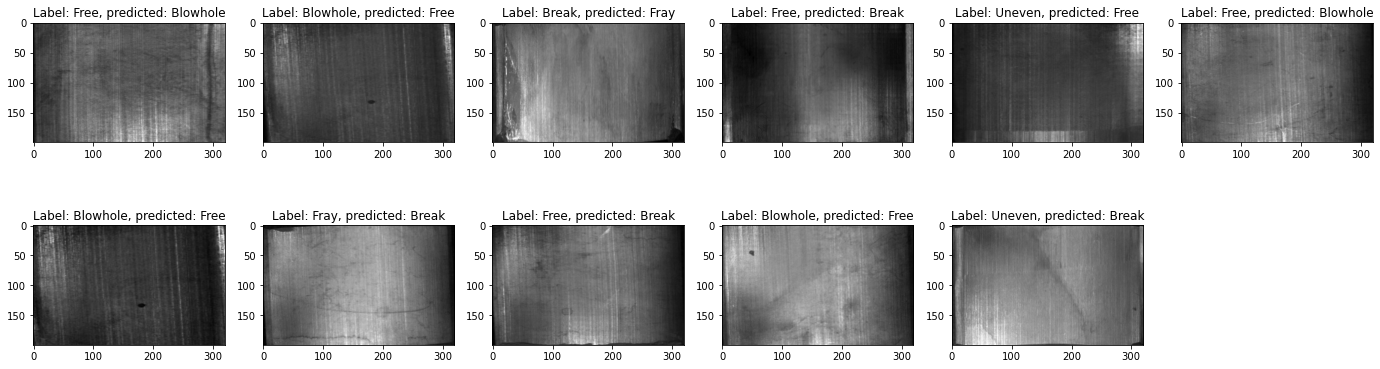

In [24]:
#investigate wrong predictions
Ypred = model.predict(X_test_pp).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]

# Disaplying some samples that have been predicted incorrectly
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 11, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    aux = X_test_pp[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.title("Label: %s, predicted: %s" %(class_names[Y_test[wrong_indexes[jj]]],class_names[Ypred[wrong_indexes[jj]]]))
plt.show()

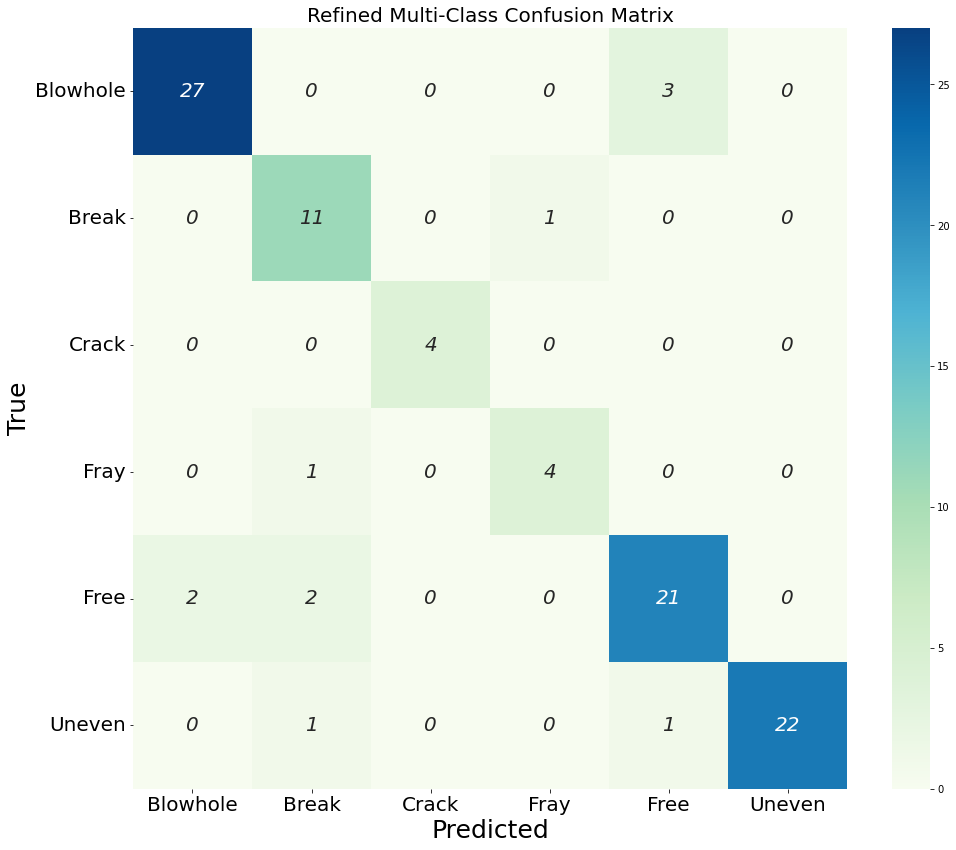

In [37]:
### Confusion Matrix

predictions = model.predict(X_test_pp, steps=len(X_test_pp), verbose=0)

y_pred = np.argmax(predictions, axis=-1)

y_true=np.argmax(Y_test_oh, axis=-1)

cm = confusion_matrix(y_true, y_pred)

## Get Class Labels


# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
annot_kws={'fontsize':20, 
           'fontstyle':'italic'}
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g',cmap='GnBu',annot_kws= annot_kws); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=25)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=0)
ax.xaxis.set_ticklabels(class_names, fontsize = 20)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=25)
ax.yaxis.set_ticklabels(class_names, fontsize = 20)
plt.yticks(rotation=0)

plt.title('Refined Multi-Class Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

In [26]:
Y_pred=model.predict(X_test_pp)

In [27]:
#percision, recall and F1 score for different classes is claculated
y_pred=np.argmax(Y_pred,axis=1)

print(classification_report(Y_test, y_pred,target_names=class_names))

              precision    recall  f1-score   support

    Blowhole       0.93      0.90      0.92        30
       Break       0.73      0.92      0.81        12
       Crack       1.00      1.00      1.00         4
        Fray       0.80      0.80      0.80         5
        Free       0.84      0.84      0.84        25
      Uneven       1.00      0.92      0.96        24

    accuracy                           0.89       100
   macro avg       0.88      0.90      0.89       100
weighted avg       0.90      0.89      0.89       100



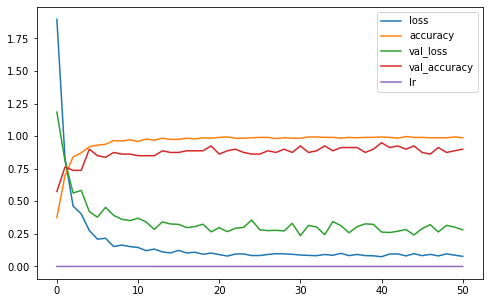

In [28]:
#training and validation loss and accuracy curves are illustrated
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [29]:
#Grad CAM

#last convolutional layer of the model is removed in order to implement Grad-CAM

layer_name='Conv_1_bn'
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output,
                                                    model.output])
grad_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 160, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 160, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 50, 80, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 51, 81, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 25, 40, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 25, 40, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 13, 20, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 13, 20, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 13, 20, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 13, 20, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 13, 20, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 13, 20, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 13, 20, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 13, 20, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 10, 960)  8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 10, 960)  3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 10, 960)  0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 10, 160)   153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [30]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name,pred_index):
    #print('image shape: ',img_array.shape)
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, np.argmax(pred_index)]
        
    #print('last conv layer output:\n',last_conv_layer_output)
    #print('class channel:\n',class_channel)
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    #print('grads:\n',grads)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap_resized = resize(heatmap,(200, 320))
    return heatmap_resized

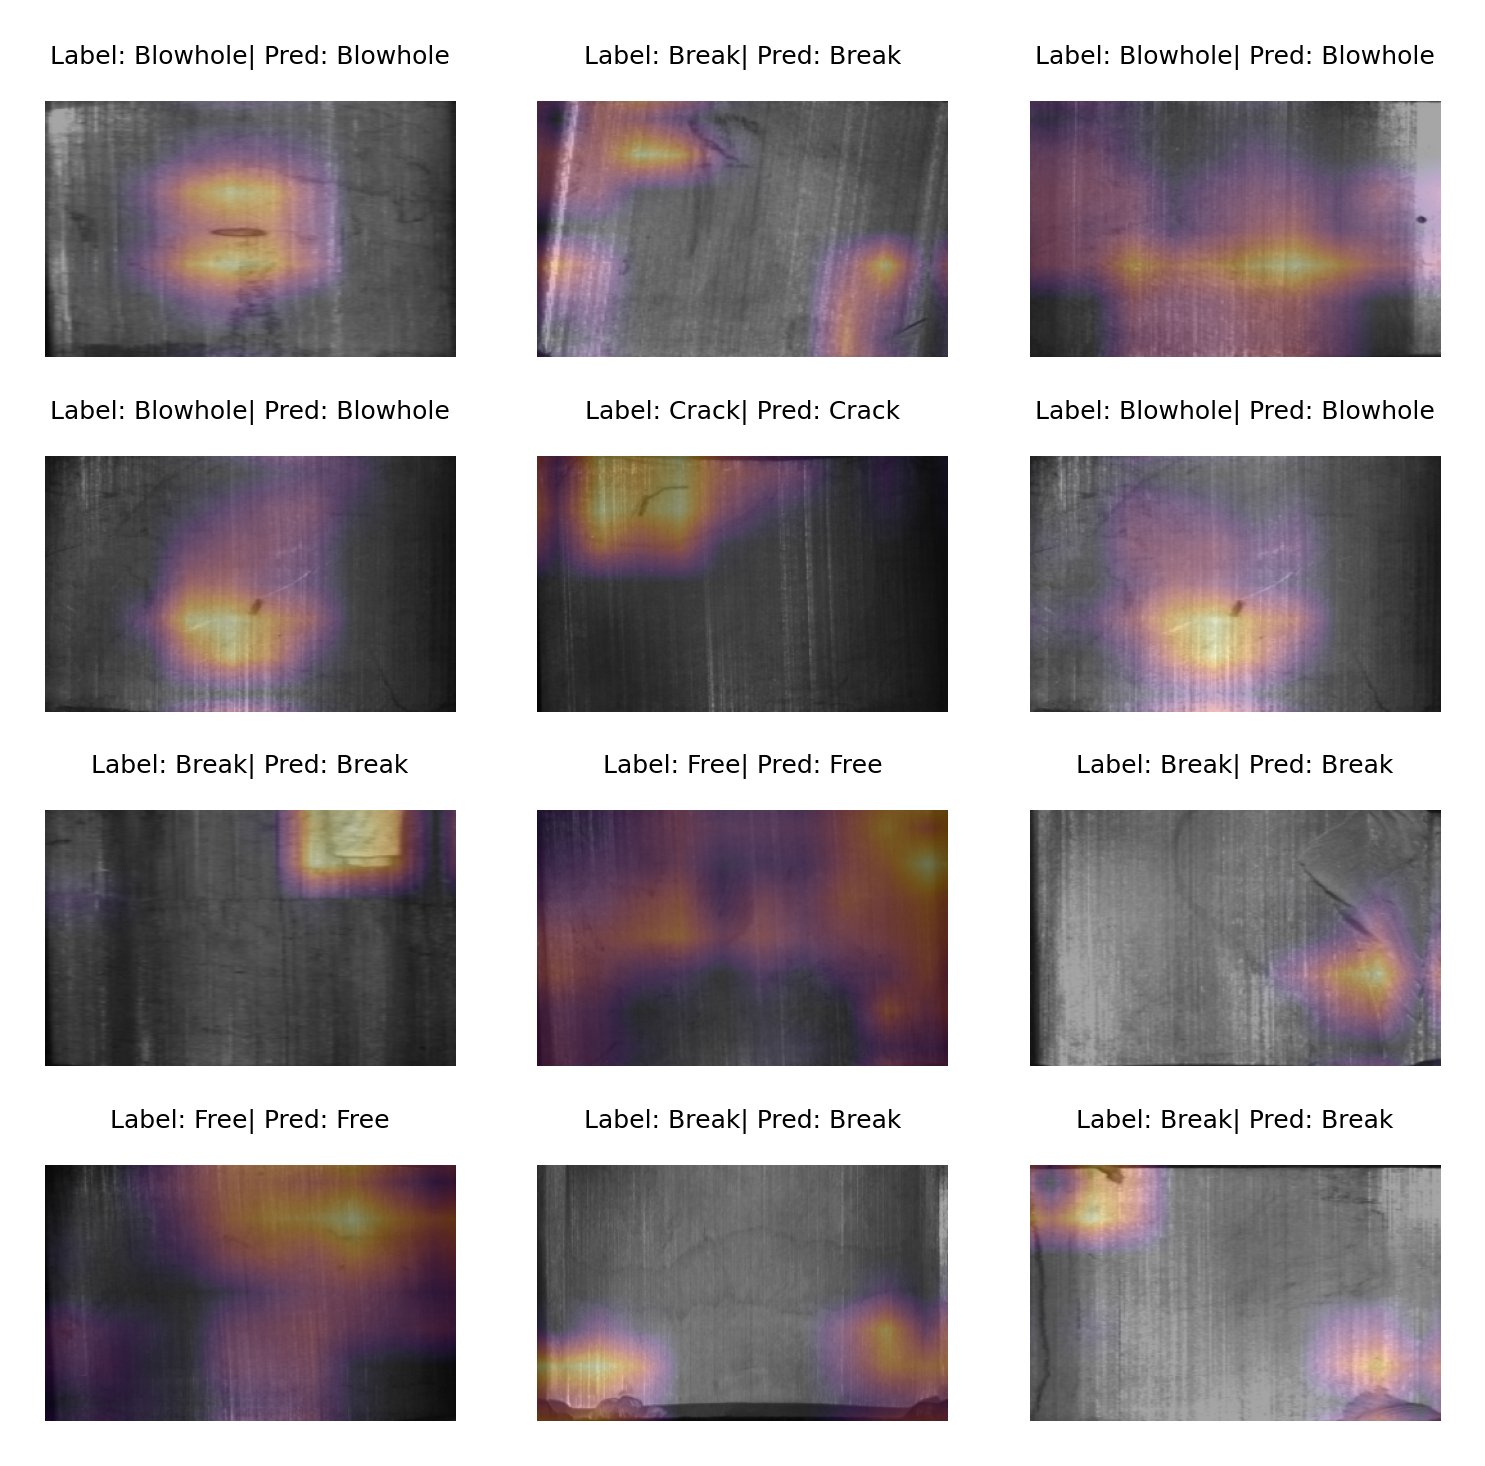

In [32]:
#random indexes are generated to generated the Heatmap for samples
sample_indexes = np.random.choice(np.arange(len(X_test_pp), dtype = int),size = 12, replace = False)


# Remove last layer's sigmoid
model.layers[-1].activation = None


plt.figure(figsize = (4,4),dpi = 450)
i=0
for ii in sample_indexes:
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(X_test_pp[ii][np.newaxis,:,:], model, "Conv_1_bn",Y_pred[ii])
    plt.subplot(4,3,i+1)
    plt.imshow(X_test[ii])
    plt.title('Label: '+class_names[Y_test[ii]]+'| Pred: '+class_names[np.argmax(Y_pred,axis=1)[ii]],fontdict = {'fontsize' : 4})
    plt.imshow(heatmap, alpha = 0.35, cmap = "inferno")
    #plt.colorbar()
    plt.axis("off")
    i+=1
plt.show()

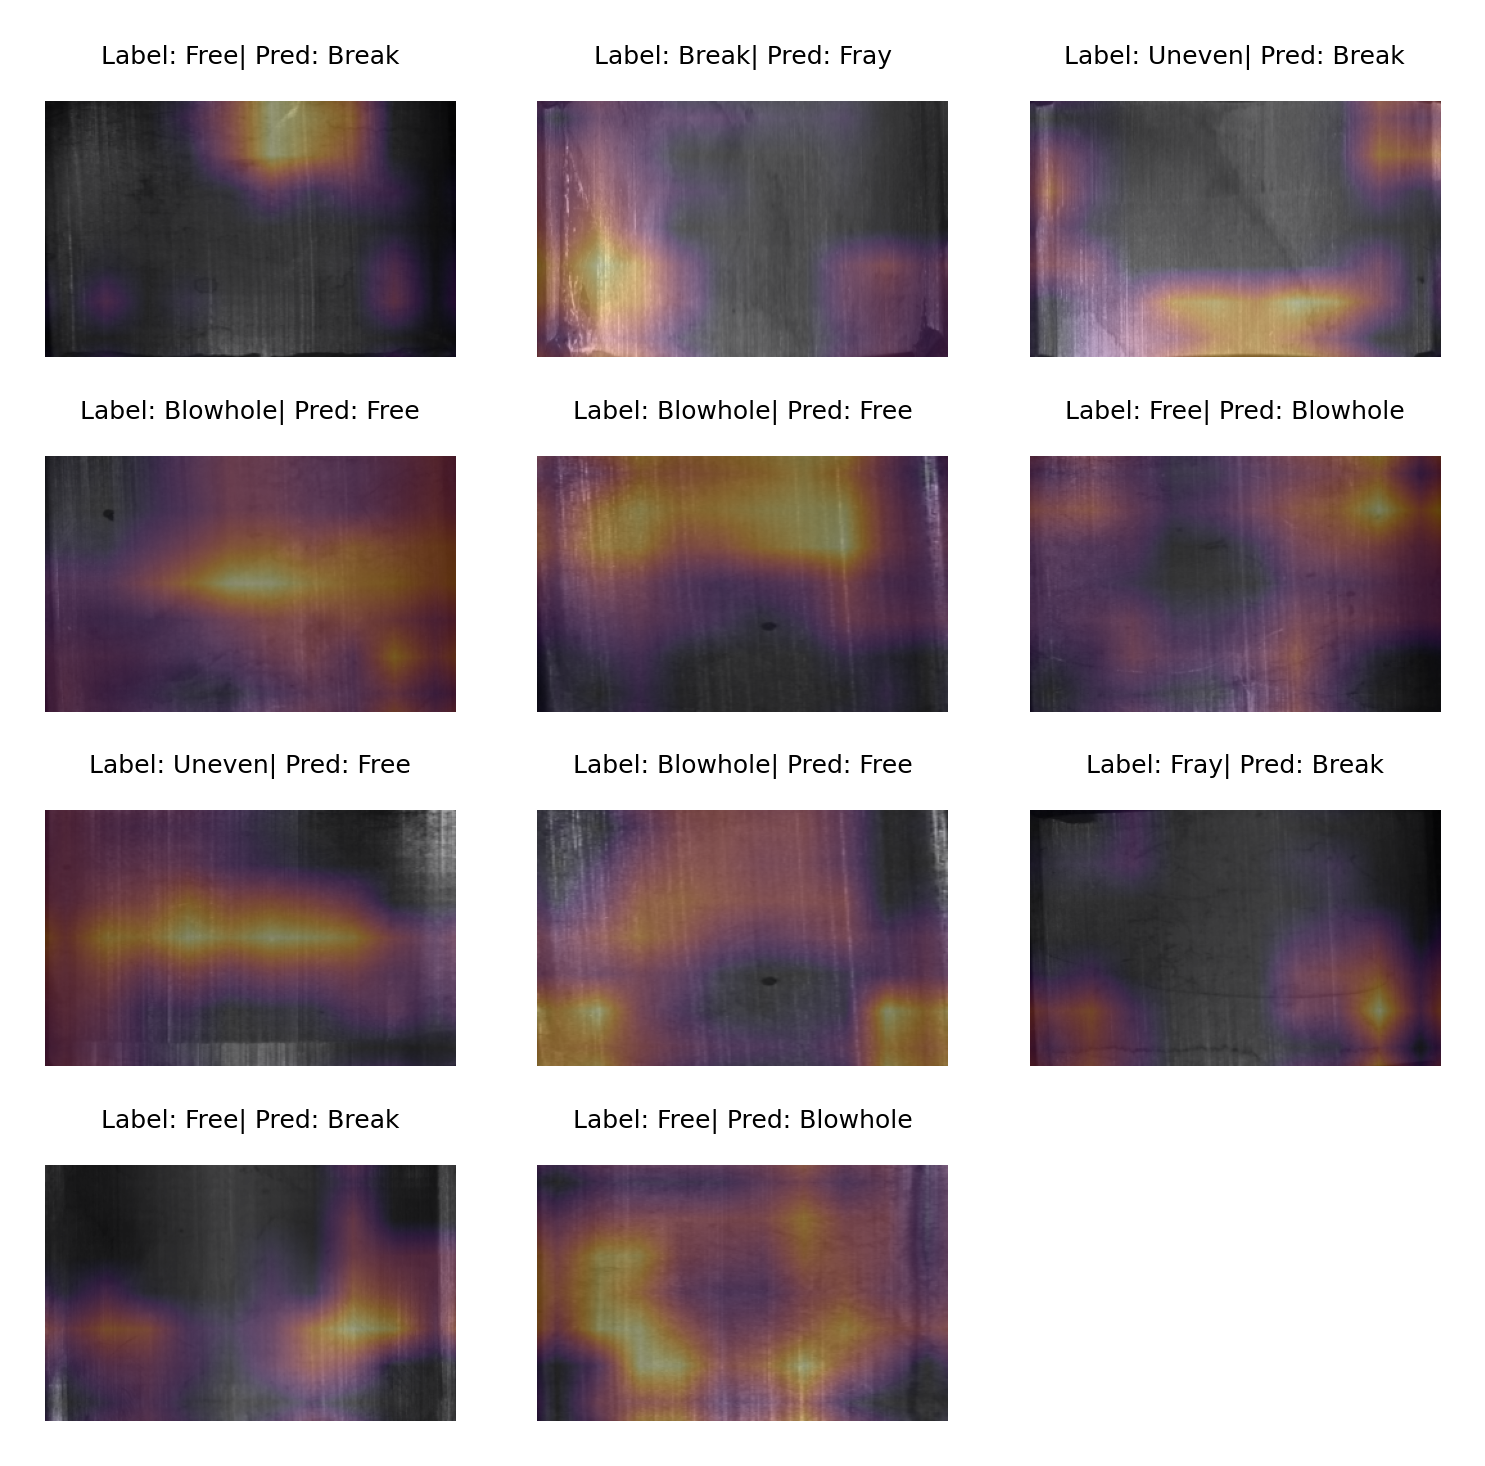

In [33]:
#checking grad-cam on incorrectly predicted samples

# Remove last layer's sigmoid
model.layers[-1].activation = None
plt.figure(figsize = (4,4),dpi = 450)
i=0
for ii in wrong_indexes:
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(X_test_pp[ii][np.newaxis,:,:], model, "Conv_1_bn",Y_pred[ii])
    plt.subplot(4,3,i+1)
    plt.imshow(X_test[ii])
    plt.title('Label: '+class_names[Y_test[ii]]+'| Pred: '+class_names[np.argmax(Y_pred,axis=1)[ii]],fontdict = {'fontsize' : 4})
    plt.imshow(heatmap, alpha = 0.35, cmap = "inferno")
    #plt.colorbar()
    plt.axis("off")
    i+=1
plt.show()